# Python toolkit for fluorescence data processing

Author: Yongmin Hu (yongmin.hu@eawag.ch)

Last update: 2023-04-07

Before running the toolkit, please go through checklist_fluorescence_python_toolkit.doc.

If you change the input in any of the code blocks, please re-run all blocks after.

# 0. Import packages

In [2]:
import importlib

try:
    importlib.import_module('tensorly')
    importlib.import_module('cv2')
    importlib.import_module('ipywidgets')
except ImportError:
    !pip install tensorly
    !pip install opencv-python
    !pip install ipywidgets

import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import re

from datetime import datetime, timedelta, date
from EEMprocessing import *
from generate_widgets import *
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import Layout, Button, Dropdown, Label, FloatText, Text, IntSlider, Checkbox, Box
from IPython.display import display, clear_output
from traitlets import traitlets


matplotlib.rcParams['figure.dpi'] = 80


-------------------------------------------
# 1. Specify data directory and filename format

In [3]:
# read all filenames in the target directory
filedir_default = '_data/_greywater/20220111_GW_C2' # Just the default, could be changed

Part1_widgets = Widgets_read_data(filedir_default)
data_selection = Part1_widgets.generate_widgets()
display(data_selection)


Box(children=(VBox(children=(Label(value='Pleae specify the directory of fluorescence data in the text box bel…

-----------------------------------------
# 2. Data preview and parameter selection

In [4]:
%matplotlib inline

# Visualization with interaction
datdir = Part1_widgets.dir_selection.value
filelist = os.listdir(datdir)
datlist = [file for file in filelist if 'PEM.dat' in file]
data_index = []
if Part1_widgets.ts_read_from_filename.value:
    tslist = [get_TS_from_filename(file, ts_format=Part1_widgets.ts_format.value, 
                                   ts_start_position=Part1_widgets.ts_start_position.value-1,
                                   ts_end_position=Part1_widgets.ts_end_position.value) for file in datlist]
    tslist_sortidx = np.argsort(tslist)
    tslist_sorted = [tslist[i] for i in tslist_sortidx]
    datlist = [datlist[i] for i in tslist_sortidx]
else:
    data_index = [file[:-4] for file in datlist]
    
# --------------Create widgets for plotting parameters-------------

intensity_range = (0,3000,100) # (min, max, step）
em_range = (300,600,2)
ex_range = (250,400,2)

ts_format = Part1_widgets.ts_format.value
ts_start_position = Part1_widgets.ts_start_position.value
ts_end_position = Part1_widgets.ts_end_position.value

Part2and3_widgets = Widgets_create_stack(intensity_range, em_range, ex_range, datdir, datlist, ts_format, ts_start_position,
                 ts_end_position)
tab2, note_step2, out_parameters = Part2and3_widgets.generate_widgets()

display(tab2, note_step2, out_parameters)


Output()

----------------------------------------------------
# 3. Stack data

For further analysis, the parameters would be set according to the settings in the above interface!

PLEASE CHECK THE SETTINGS before going-on!


In [94]:
#-------------------------Stack data------------------------------
stacking_interact = Part2and3_widgets.generate_widgets2()
caption = ipywidgets.Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')
display(caption, stacking_interact)

Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')

interactive(children=(Text(value='PEM.dat', description='Filename searching keyword: ', style=DescriptionStyle…

------------------------------------------
# 4. Remove unwanted data from the data stack

Please run the code block even if you don't want to do any operation here.

In [91]:
#------------------Remove specific data from the data stack-----------------

eem_stack_all, em_range_cw, ex_range_cw, datlist_all, abs_stack, ex_range_abs = stacking_interact.result

Part4_widgets = Widgets_data_cleaning(eem_stack_all, datlist_all, em_range_cw, ex_range_cw, Part2and3_widgets.preview_parameter_dict)


manual_detection = Part4_widgets.generate_widgets_1()

# auto cleaning
auto_detection = Part4_widgets.generate_widgets_2()

artefact_imputing = Part4_widgets.generate_widgets_3()

tab4 = ipywidgets.Tab()
tab4.children = [manual_detection, auto_detection, artefact_imputing]
tab4.set_title(0, 'Manual artefact detection')
tab4.set_title(1, 'Auto artefact detection')
tab4.set_title(2, 'Artefact imputing')


caption = ipywidgets.Label(
    'This block is used to remove specific data from the data stack. Please select the data you want to remove:')
caption2 = ipywidgets.Label(
    "To reset the data stack to its original state: re-run the block. If you don't want to make any changes here,"
    " please skip.")

display(caption, tab4, caption2)


Label(value='This block is used to remove specific data from the data stack. Please select the data you want t…

Label(value="To reset the data stack to its original state: re-run the block. If you don't want to make any ch…

-------------------------------------
# 5. Data stack analysis

Output()

Output()

Similarity of each test:


,test 1: AB vs. CD,test 2: AC vs. BD,test 3: AD vs. BC
component 1,0.999210,0.999236,0.991481
component 2,0.995236,0.997555,0.973158
component 3,0.995922,0.996824,0.940956
component 4,0.992095,0.994707,0.981182


<Figure size 1200x400 with 0 Axes>

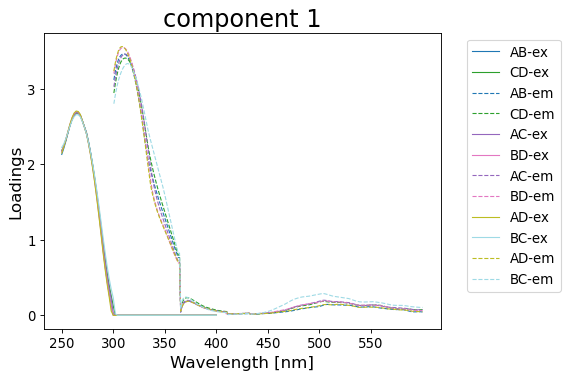

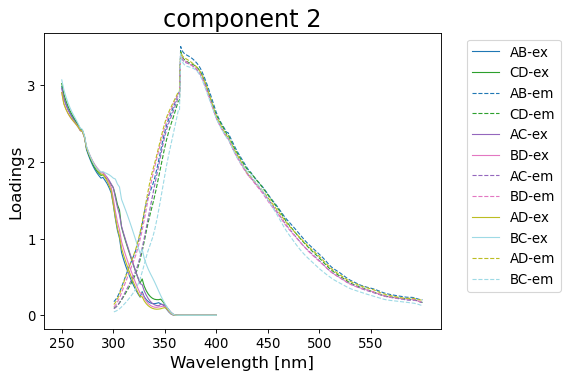

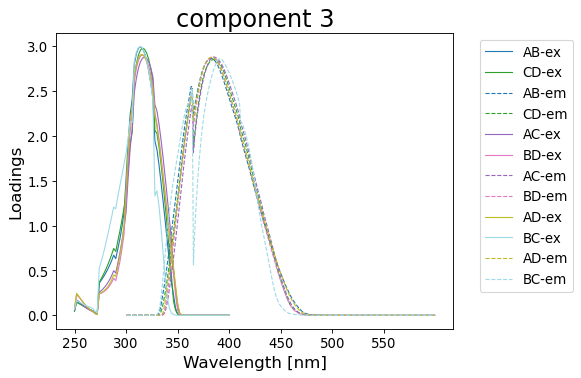

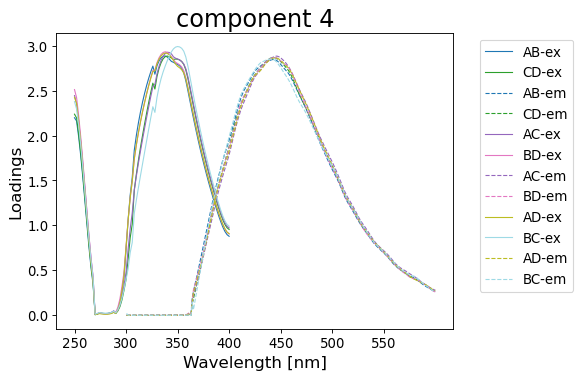

In [92]:
%matplotlib inline
#--------------------Data stack analysis---------------
pd.set_option('display.max_rows', None)
datlist_filtered = Part4_widgets.datlist_filtered
idx2remove = Part4_widgets.idx2remove

# Update the eem_stack after artefact removal
data_index_cw = []

if datlist_filtered==datlist_all:
    datlist_cw = datlist_all.copy()
    eem_stack_cw = Part4_widgets.eem_stack_imputed.copy()
else:
    datlist_cw = datlist_filtered[:]
    eem_stack_cw = np.delete(Part4_widgets.eem_stack_imputed, idx2remove, 0)
    
if Part1_widgets.ts_read_from_filename.value:
    timestamps_cw = [get_TS_from_filename(dat, Part1_widgets.ts_format.value, 
                                          Part1_widgets.ts_start_position.value-1, 
                                          Part1_widgets.ts_end_position.value)
                for dat in datlist_cw ]
    timestamps_cw_sortidx = np.argsort(timestamps_cw)
    timestamps_cw = [timestamps_cw[i] for i in timestamps_cw_sortidx]
    datlist_cw = [datlist_cw[i] for i in timestamps_cw_sortidx]
    eem_stack_cw = eem_stack_cw[timestamps_cw_sortidx]
else:
    data_index_cw = [file[:-4] for file in datlist_cw]
    timestamps_cw = None

#---------------Create widgets------------------------
#----------------General widgets------------
out = ipywidgets.Output()
display(out)

button_clear_display=ipywidgets.Button(description='Clear display')
def clear_display_with_button(b):
    clear_output()
    display(tab)
button_clear_display.on_click(clear_display_with_button)

#-------Tab1: File range selection----------

Part51_widgets = Widgets_stack_processing.Widgets_data_range(datlist_cw)
data_range_items, range1, range2 = Part51_widgets.generate_widgets()

data_range = Box(data_range_items,
                 layout=Layout(display='flex', flex_flow='column', border='none', align_items='stretch', width='80%'))


#-------Tab2: Pixel statistics------------------

Part52_widgets = Widgets_stack_processing.Widgets_pixel_statistics(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw)
pixel_statistics_items = Part52_widgets.generate_widgets()

pixel_statistics_items.append(ipywidgets.Box([button_clear_display]))
pixel_statistics = Box(pixel_statistics_items, 
                       layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab3: EEM statistics---------

Part53_widgets = Widgets_stack_processing.Widgets_eem_statistics(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw, 
                           Part2and3_widgets.crange_cw)
eem_statistics_items = Part53_widgets.generate_widgets()

eem_statistics_items.append(ipywidgets.Box([button_clear_display]))

eem_statistics = Box(eem_statistics_items, 
                     layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

#-------Tab4: Regional integration------------

Part54_widgets = Widgets_stack_processing.Widgets_regional_integration(eem_stack_cw, datlist_cw, range1, range2, em_range_cw, ex_range_cw, timestamps_cw)

integration_items = Part54_widgets.generate_widgets()
integration_items.append(ipywidgets.Box([button_clear_display]))
region_integration = Box(integration_items, 
                         layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='60%'))


#-------Tab5: PARAFAC----------

Part55_widgets = Widgets_stack_processing.Widgets_decomposition(data_index, data_index_cw, timestamps_cw, eem_stack_cw, datlist_cw, range1, 
                         range2, em_range_cw, ex_range_cw)
decomposition_items = Part55_widgets.generate_widgets()
decomposition = Box(decomposition_items, 
                    layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='100%'))

Part56_widgets = Widgets_stack_processing.Widgets_nc_optimization(eem_stack_cw, Part55_widgets.decomposition_method_list,
                                                                 Part55_widgets.init, Part55_widgets.dataset_normalization,
                                                                 datlist_cw, range1, range2)
nc_optimization_items = Part56_widgets.generate_widgets()
nc_optimization_items.append(ipywidgets.Box([button_clear_display]))
nc_optimization = Box(nc_optimization_items, 
                      layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))


Part57_widgets = Widgets_stack_processing.Widgets_reconstruction(Part55_widgets.decomposition_method_list, Part55_widgets.rank_display, Part55_widgets.init,
                           Part2and3_widgets.crange_cw, data_index, data_index_cw, timestamps_cw, eem_stack_cw, 
                           datlist_cw, range1, range2, em_range_cw, ex_range_cw, Part55_widgets.dataset_normalization)

reconstruction_items, pixel_error_interact = Part57_widgets.generate_widgets()
reconstruction_items.append(ipywidgets.Box([button_clear_display]))
# reconstruction_items.append(pixel_error_interact)
reconstruction = Box(reconstruction_items, 
                     layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))

Part58_widgets = Widgets_stack_processing.Widgets_split_validation(eem_stack_cw, em_range_cw, ex_range_cw, Part55_widgets.rank_display, Part55_widgets.init,
                           Part55_widgets.decomposition_method_list, datlist_cw, range1, range2,
                           Part55_widgets.dataset_normalization)
split_validation_items = Part58_widgets.generate_widgets()
split_validation_items.append(ipywidgets.Box([button_clear_display]))
split_validation = Box(split_validation_items, 
                   layout=Layout(display='flex',flex_flow='column',border='none',align_items='stretch',width='80%'))


tab_parafac = ipywidgets.Tab()
tab_parafac.children = [decomposition, nc_optimization, reconstruction, split_validation]
tab_parafac.set_title(0, 'Decomposition')
tab_parafac.set_title(1, 'Optimize N_components')
tab_parafac.set_title(2, 'Reconstruction error')
tab_parafac.set_title(3, 'Split validation')


# -----------------Assembly tabs-------------------

tab = ipywidgets.Tab() 
tab.children=[data_range, pixel_statistics, eem_statistics, region_integration, tab_parafac]

tab.set_title(0, '1. Data range selection')
tab.set_title(1, '2. Pixel statistics')
tab.set_title(2, '3. EEM statistics')
tab.set_title(3, '4. Region integraion')
tab.set_title(4, '5. PARAFAC')
tab.set_title(5, '6. PARAFAC reconstruction')
display(tab, pixel_error_interact)

# 6. Save PARAFAC result

In [47]:
try:
    score_df, exl_df, eml_df, fmax_df = Part55_widgets.button_decomposition_interact.result

    Part6_widgets = Widgets_export_parafac(score_df, exl_df, eml_df, Part1_widgets.dir_selection.value, Part2and3_widgets.inner_filter_effect, 
                         Part2and3_widgets.raman_scattering_correction, Part2and3_widgets.rayleigh_scattering_correction,
                         Part2and3_widgets.gaussian_smoothing, 
                         Part55_widgets.decomposition_method_list, Part55_widgets.dataset_normalization)
    output_items = Part6_widgets.generate_widgets()
    decomposition_output = Box(output_items, layout=Layout(
        display='flex',
        flex_flow='column',
        border='none',
        align_items='stretch',
        width='80%'
    ))
    display(decomposition_output)
except TypeError:
    print('No PARAFAC model found. Please conduct PARAFAC first.')

Box(children=(Box(children=(Label(value='Mandatory fields are marked with *'),)), Box(children=(Text(value='_d…

In [12]:
from scipy.io import savemat

X_out = eem_stack_cw

# transpose second and third axes
X_out = np.transpose(X_out, (0, 2, 1))

# flip third axis
X_out = np.flip(X_out, axis=2)


Ex_out = ex_range_cw
Em_out = em_range_cw

out = {'X':X_out, 'Ex':Ex_out, 'Em':Em_out, 'nSample':X_out.shape[0], 'nEm':X_out.shape[1], 'nEx':X_out.shape[2]}

savemat('C:/PhD/drEEM-0.6.5/tutorials_demos/datasets/mydata/G3.mat', {'G3': out})